# Classifieurs
Après avoir établi nos 10 attributs et notre distance privilégiée, nous pouvons finalement évaluer différents classifieurs. Tel que demandé, nous évaluerons trois algorithmes: plus proche centroid (NC), K plus proches voisins (KNN) et une mixture de gaussienne (GMM). Nous avons déjà évaluer le premier algorithme dans les deux derniers notebooks, mais nous rappelons les résultats ici. Il est important de mentionner que nous ignorons les performances sur la classe 2 car celle-ci contient seulement deux instances en plus de ne pas être facilement distinguable dans les nuages de points. Nous assumons qu'aucun modèle sera en mesure de bien la classifier en raison du faible nombre d'observations.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from models import KNN, NearestCentroid

# Meilleure métrique obtenue à la dernière question
best_distance_metric = "mahalanobis"
# Chargement des données
df = pd.read_csv("./QSAR_10best_dataset.csv")
features = list(set(df.columns) - {"Class"})
# Conversion des données en format numpy
X = df.loc[:, df.columns != "Class"].to_numpy()
y_true = df.loc[:, "Class"].to_numpy()
# Conversion des étiquettes en valeurs numériques pour faciliter leur traitement par numpy
le = LabelEncoder()
le.fit(y_true)
# Les données devraient déjà être centrées et réduites
assert np.allclose(X.mean(), 0, atol=1e-10), "Les données ne sont pas centrées"
assert np.allclose(X.std(), 1, atol=1e-2), "Les données ne sont pas réduites"
# Séparation en jeu de test et jeu d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.25, random_state=0)

In [25]:
# Classifieur K Nearest Neighbors
n_neighbors = 5
_, counts = np.unique(y_true, return_counts=True)
weights = counts/counts.sum()

knn_clf = KNN(5, le, weights, metric=best_distance_metric)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
knn_df = knn_clf.evaluate(y_test, y_pred)
knn_df

(51, 151)


,Class -1,Class -2,Class 0,Class 1,accuracy,macro avg,weighted avg
precision,0.818182,0.857143,0.538462,0.769231,0.745098,0.745754,0.749055
recall,0.642857,1.000000,0.583333,0.769231,0.745098,0.748855,0.745098
f1-score,0.720000,0.923077,0.560000,0.769231,0.745098,0.743077,0.742685
support,14.000000,12.000000,12.000000,13.000000,0.745098,51.000000,51.000000


In [26]:
# Classifieur NearestCentroid
nc_clf = NearestCentroid(le, metric=best_distance_metric)
nc_clf.fit(X_train, y_train)
y_pred = nc_clf.predict(X_test)
nc_df = nc_clf.evaluate(y_test, y_pred)
nc_df

,Class -1,Class -2,Class 0,Class 1,accuracy,macro avg,weighted avg
precision,0.875000,1.000000,0.423077,0.833333,0.666667,0.782853,0.787456
recall,0.500000,0.916667,0.916667,0.384615,0.666667,0.679487,0.666667
f1-score,0.636364,0.956522,0.578947,0.526316,0.666667,0.674537,0.670134
support,14.000000,12.000000,12.000000,13.000000,0.666667,51.000000,51.000000


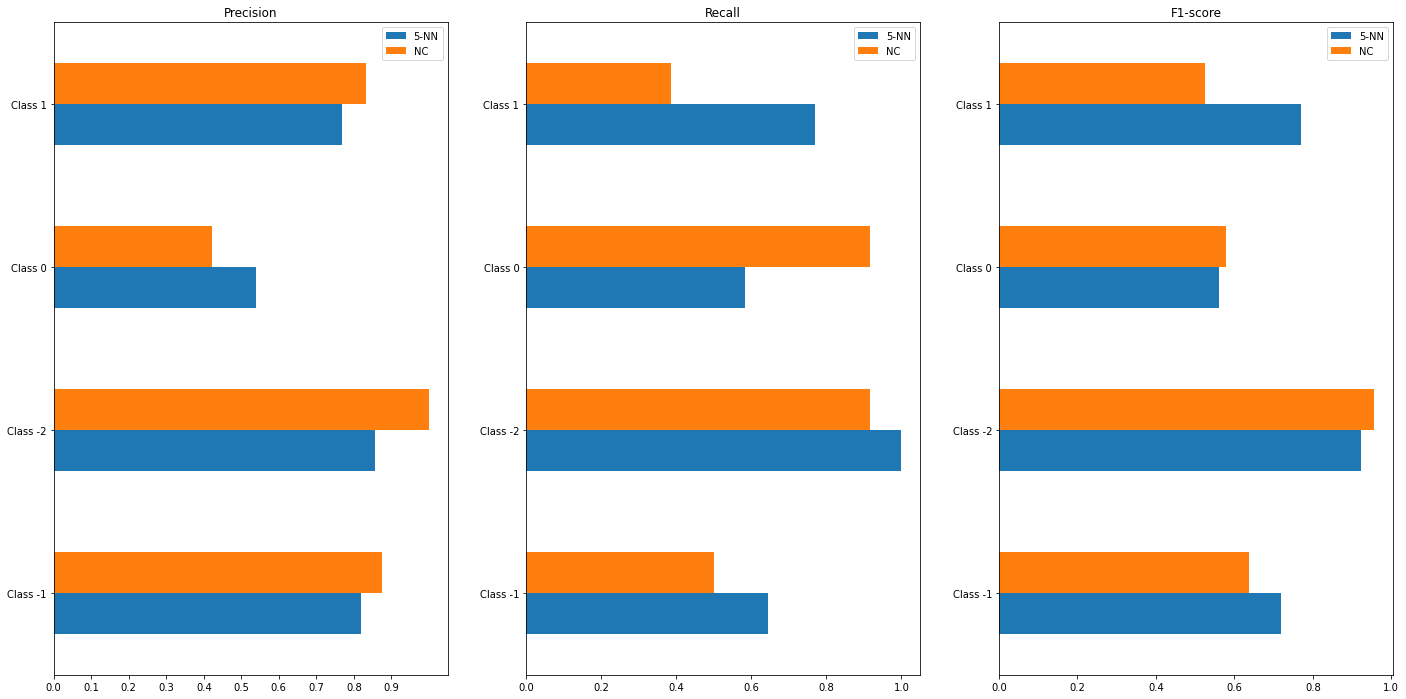

In [27]:
# Affichage des résultats
f, axs = plt.subplots(1, 3, figsize=(24, 12))

df_precision = pd.concat([
    knn_df.loc["precision"][0:4].rename("5-NN"), 
    nc_df.loc["precision"][0:4].rename("NC")
], axis=1)
df_recall = pd.concat([
    knn_df.loc["recall"][0:4].rename("5-NN"), 
    nc_df.loc["recall"][0:4].rename("NC")
], axis=1)
df_f1 = pd.concat([
    knn_df.loc["f1-score"][0:4].rename("5-NN"), 
    nc_df.loc["f1-score"][0:4].rename("NC")
], axis=1)

df_precision.plot(kind="barh", ax=axs[0])
df_recall.plot(kind="barh", ax=axs[1])
df_f1.plot(kind="barh", ax=axs[2])

axs[0].set_title("Precision")
axs[0].set_xticks(np.arange(0, 1, step=0.1))
axs[1].set_title("Recall")
axs[2].set_title("F1-score")

plt.show()

Le graphique nous montre la supériorité de l'approche KNN par rapport à CN. L'algorithme CN performe mieux en terme de Precision pour l'ensemble des classes à l'exception de la classe 0. Cela indique que cet algorithme produit moins de faux positifs que le KNN. Par contraste, le KNN produit moins de faux négatifs avec un meilleur Recall (à l'exception de la classe 0). Lorsqu'on prend la moyenne harmonique des deux métriques de performance, le KNN performe mieux, mais par une légère marge seulement.

Entraînons maintenant le modèle GMM.

In [28]:
y_train, y_test = le.transform(y_train), le.transform(y_test)

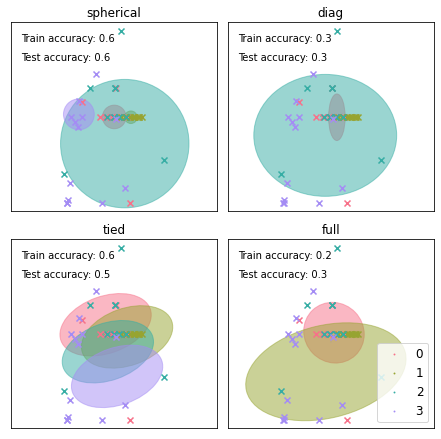

In [29]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# Modified by Aida Ouangraoua <aida.ouangraoua@usherbrooke.com>
# Modified by Nadia Tahiri <Nadia.Tahiri@USherbrooke.com>
# Initial code at https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import seaborn as sns

colors = sns.color_palette("husl", 4)

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

n_classes = 4

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=100, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

for index, (name, estimator) in enumerate(estimators.items()):

    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    e = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = X[y_true == n]
        plt.scatter(data[:, 0], data[:, 1], s = 0.8, color=color, label=n)
        
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred==y_train)
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred==y_test)
    
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))

plt.show()

Selon résultats obtenus, le paramètre par défaut ("spherical") produit les meilleurs résultats.

In [30]:
from sklearn import metrics

gmm_clf = GaussianMixture(n_components=n_classes, covariance_type="spherical", max_iter=100)
gmm_clf.means_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])
gmm_clf.fit(X_train, y_train)
y_pred = gmm_clf.predict(X_test)
gmm_df = metrics.classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred), output_dict=True)
gmm_df = pd.DataFrame.from_dict(gmm_df)

On compare maintenant les trois approches

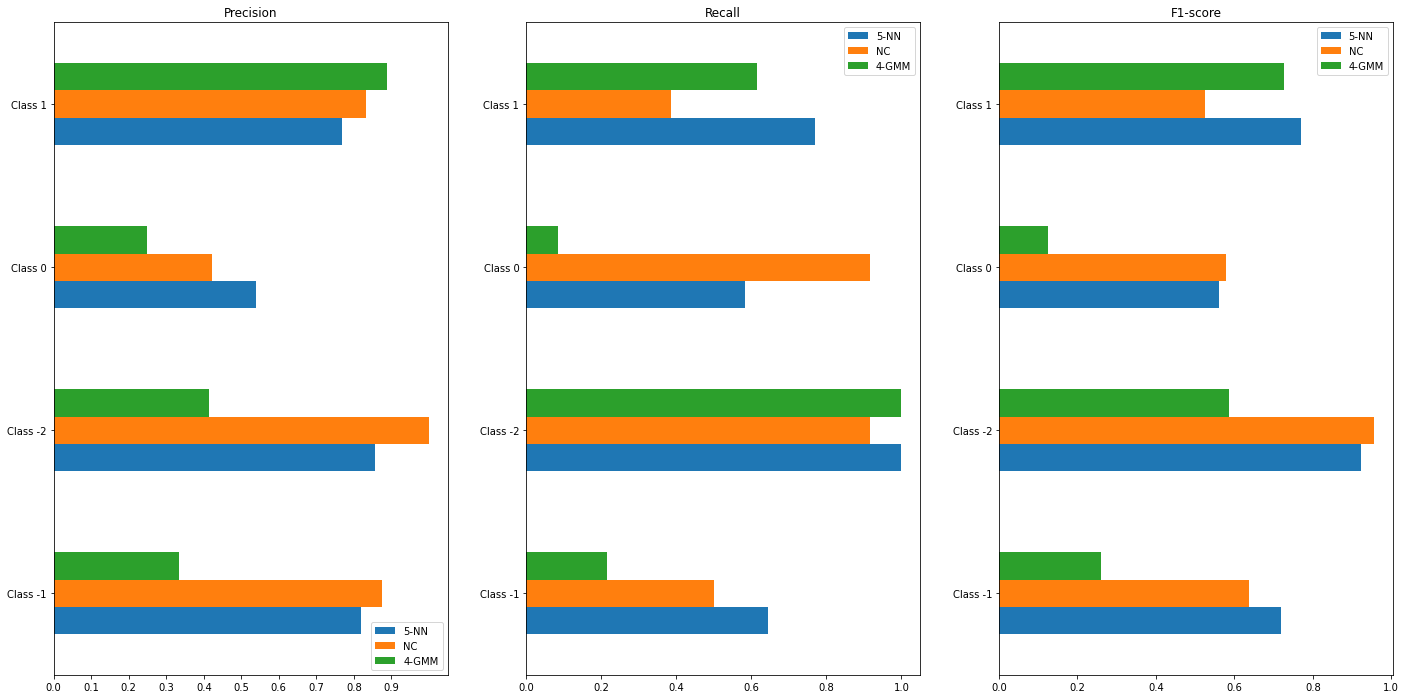

In [31]:
# Affichage des résultats
f, axs = plt.subplots(1, 3, figsize=(24, 12))

df_precision = pd.concat([
    knn_df.loc["precision"][0:4].rename("5-NN"), 
    nc_df.loc["precision"][0:4].rename("NC"),
    gmm_df.loc["precision"][0:4].rename("4-GMM")
], axis=1)
df_recall = pd.concat([
    knn_df.loc["recall"][0:4].rename("5-NN"), 
    nc_df.loc["recall"][0:4].rename("NC"),
    gmm_df.loc["recall"][0:4].rename("4-GMM")
], axis=1)
df_f1 = pd.concat([
    knn_df.loc["f1-score"][0:4].rename("5-NN"), 
    nc_df.loc["f1-score"][0:4].rename("NC"),
    gmm_df.loc["f1-score"][0:4].rename("4-GMM")
], axis=1)

df_precision.plot(kind="barh", ax=axs[0])
df_recall.plot(kind="barh", ax=axs[1])
df_f1.plot(kind="barh", ax=axs[2])

axs[0].set_title("Precision")
axs[0].set_xticks(np.arange(0, 1, step=0.1))
axs[1].set_title("Recall")
axs[2].set_title("F1-score")

plt.show()

Les résultats confirment la supériorié de l'approche KNN. Le F1-score du GMM pour la classe 0 est particulièrement bas. Le KNN est plus consistant dans ses performances avec des résultats plus constants peu importe la classe.

Finalement, on peut prédire les classes des données de tests.

In [36]:
best_clf = knn_clf
df_test = pd.read_excel("./test_TP1.xlsx")
X_test = df_test.loc[:, features].to_numpy()
y_pred = best_clf.predict(X_test)
y_pred

(2, 151)


array(['Class -1', 'Class 0'], dtype=object)